# 04. Data Preprocessing

In this notebook, we perform data preprocessing for different machine learning models.
The steps include:
- Loading the feature-engineered datasets
- Imputing missing values based on the training set
- Applying model-specific preprocessing:
  - Logistic Regression: scaling and one-hot encoding
  - Random Forest: use imputed features directly
  - XGBoost: same as Random Forest
  - LightGBM: convert categorical columns to 'category' dtype
- Saving the preprocessed datasets for each model


In [7]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

import pandas as pd
from pathlib import Path
import importlib
import scripts.preprocessing
importlib.reload(scripts.preprocessing)

from scripts.preprocessing import (
    impute_missing_values,
    preprocess_for_logistic,
    select_low_vif_features,
    preprocess_for_tree_models,
    preprocess_for_lightgbm
)

In [8]:
TRAIN_PATH = Path('../data/processed/train_fe.csv')
VAL_PATH = Path('../data/processed/val_fe.csv')
TEST_PATH = Path('../data/processed/test_fe.csv')

OUTPUT_DIR = Path('../data/processed/')

In [9]:
df_train = pd.read_csv(TRAIN_PATH)
df_val = pd.read_csv(VAL_PATH)
df_test = pd.read_csv(TEST_PATH)

In [10]:
df_train

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,mean_arterial_pressure,vision_avg,hearing_avg,AST_ALT_ratio,risk_waist,risk_bp,risk_tg,risk_chole,risk_glu,metabolic_risk_count
0,Female,45,170,70,85.5,1.0,1.2,1.0,1.0,108.0,...,81.333333,1.10,1.0,2.125000,1,0,0,1,0,2
1,Female,55,160,65,79.0,0.8,0.7,1.0,1.0,114.0,...,83.333333,0.75,1.0,1.384615,0,0,0,1,1,2
2,Female,55,155,80,101.9,0.9,1.0,1.0,1.0,116.0,...,83.333333,0.95,1.0,0.736842,1,0,1,0,1,3
3,Female,65,150,55,75.0,0.9,0.8,1.0,1.0,136.0,...,101.333333,0.85,1.0,1.400000,0,1,1,1,0,3
4,Female,40,155,60,85.0,0.9,1.2,1.0,1.0,117.0,...,85.000000,1.05,1.0,1.545455,1,0,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693937,Female,55,155,55,78.0,0.3,0.5,1.0,1.0,113.0,...,85.000000,0.40,1.0,1.000000,0,0,0,0,0,0
693938,Male,40,175,90,86.0,0.9,1.0,1.0,1.0,105.0,...,78.333333,0.95,1.0,1.172414,0,0,1,1,1,3
693939,Male,60,170,75,92.0,2.0,1.2,1.0,1.0,126.0,...,95.333333,1.60,1.0,0.916667,1,0,0,0,1,2
693940,Male,55,170,85,92.0,0.8,0.7,1.0,1.0,130.0,...,96.666667,0.75,1.0,0.676471,1,1,1,1,1,5


In [11]:
df_train.columns

Index(['sex', 'age', 'height', 'weight', 'waistline', 'sight_left',
       'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS',
       'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
       'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT',
       'gamma_GTP', 'SMK_stat_type_cd', 'DRK_YN', 'BMI', 'pulse_pressure',
       'mean_arterial_pressure', 'vision_avg', 'hearing_avg', 'AST_ALT_ratio',
       'risk_waist', 'risk_bp', 'risk_tg', 'risk_chole', 'risk_glu',
       'metabolic_risk_count'],
      dtype='object')

In [12]:
df_train.dtypes

sex                        object
age                         int64
height                      int64
weight                      int64
waistline                 float64
sight_left                float64
sight_right               float64
hear_left                 float64
hear_right                float64
SBP                       float64
DBP                       float64
BLDS                      float64
tot_chole                 float64
HDL_chole                 float64
LDL_chole                 float64
triglyceride              float64
hemoglobin                float64
urine_protein             float64
serum_creatinine          float64
SGOT_AST                  float64
SGOT_ALT                  float64
gamma_GTP                 float64
SMK_stat_type_cd          float64
DRK_YN                     object
BMI                       float64
pulse_pressure            float64
mean_arterial_pressure    float64
vision_avg                float64
hearing_avg               float64
AST_ALT_ratio 

In [13]:
TARGET = 'DRK_YN'
# Encode target variable: map 'Y' to 1, 'N' to 0
df_train[TARGET] = df_train[TARGET].map({'Y': 1, 'N': 0})
df_val[TARGET] = df_val[TARGET].map({'Y': 1, 'N': 0})
df_test[TARGET] = df_test[TARGET].map({'Y': 1, 'N': 0})

# Align columns in all datasets to ensure they have the same columns after encoding
df_val = df_val.reindex(columns=df_train.columns, fill_value=0)
df_test = df_test.reindex(columns=df_train.columns, fill_value=0)

# One-hot encode 'sex' column in original datasets
df_train = pd.get_dummies(df_train, columns=['sex'], drop_first=True)
df_val = pd.get_dummies(df_val, columns=['sex'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['sex'], drop_first=True)

# Align columns in all datasets to avoid missing dummy columns
df_val = df_val.reindex(columns=df_train.columns, fill_value=0)
df_test = df_test.reindex(columns=df_train.columns, fill_value=0)

# Separate features and target variable
X_train = df_train.drop(columns=[TARGET])
y_train = df_train[TARGET]
X_val = df_val.drop(columns=[TARGET])
y_val = df_val[TARGET]
X_test = df_test.drop(columns=[TARGET])
y_test = df_test[TARGET]

In [14]:
X_train

,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,...,vision_avg,hearing_avg,AST_ALT_ratio,risk_waist,risk_bp,risk_tg,risk_chole,risk_glu,metabolic_risk_count,sex_Male
0,45,170,70,85.5,1.0,1.2,1.0,1.0,108.0,68.0,...,1.10,1.0,2.125000,1,0,0,1,0,2,False
1,55,160,65,79.0,0.8,0.7,1.0,1.0,114.0,68.0,...,0.75,1.0,1.384615,0,0,0,1,1,2,False
2,55,155,80,101.9,0.9,1.0,1.0,1.0,116.0,67.0,...,0.95,1.0,0.736842,1,0,1,0,1,3,False
3,65,150,55,75.0,0.9,0.8,1.0,1.0,136.0,84.0,...,0.85,1.0,1.400000,0,1,1,1,0,3,False
4,40,155,60,85.0,0.9,1.2,1.0,1.0,117.0,69.0,...,1.05,1.0,1.545455,1,0,0,1,1,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693937,55,155,55,78.0,0.3,0.5,1.0,1.0,113.0,71.0,...,0.40,1.0,1.000000,0,0,0,0,0,0,False
693938,40,175,90,86.0,0.9,1.0,1.0,1.0,105.0,65.0,...,0.95,1.0,1.172414,0,0,1,1,1,3,True
693939,60,170,75,92.0,2.0,1.2,1.0,1.0,126.0,80.0,...,1.60,1.0,0.916667,1,0,0,0,1,2,True
693940,55,170,85,92.0,0.8,0.7,1.0,1.0,130.0,80.0,...,0.75,1.0,0.676471,1,1,1,1,1,5,True


In [15]:
y_train

0         0
1         0
2         0
3         0
4         0
         ..
693937    0
693938    1
693939    1
693940    1
693941    0
Name: DRK_YN, Length: 693942, dtype: int64

In [16]:
# Impute missing values
X_train_imp, X_val_imp, X_test_imp = impute_missing_values(X_train, X_val, X_test)

In [17]:
## Identify categorical columns
categorical_cols = [col for col in X_train.columns if col.startswith('sex_')]
categorical_cols

['sex_Male']

In [18]:
# Preprocessing per model
# Logistic Regression
X_train_lr, X_val_lr, X_test_lr = preprocess_for_logistic(X_train_imp, X_val_imp, X_test_imp, categorical_cols)

# Random Forest
X_train_rf, X_val_rf, X_test_rf = preprocess_for_tree_models(X_train_imp, X_val_imp, X_test_imp)

# XGBoost
X_train_xgb, X_val_xgb, X_test_xgb = preprocess_for_tree_models(X_train_imp, X_val_imp, X_test_imp)

# LightGBM
X_train_lgb, X_val_lgb, X_test_lgb = preprocess_for_lightgbm(X_train_imp, X_val_imp, X_test_imp, categorical_cols)

In [19]:
# Save preprocessed datasets
# Logistic Regression datasets
X_train_lr.to_csv(OUTPUT_DIR / 'X_train_lr.csv', index=False)
X_val_lr.to_csv(OUTPUT_DIR / 'X_val_lr.csv', index=False)
X_test_lr.to_csv(OUTPUT_DIR / 'X_test_lr.csv', index=False)
y_train.to_csv(OUTPUT_DIR / 'y_train_lr.csv', index=False)
y_val.to_csv(OUTPUT_DIR / 'y_val_lr.csv', index=False)
y_test.to_csv(OUTPUT_DIR / 'y_test_lr.csv', index=False)

# Random Forest datasets
X_train_rf.to_csv(OUTPUT_DIR / 'X_train_rf.csv', index=False)
X_val_rf.to_csv(OUTPUT_DIR / 'X_val_rf.csv', index=False)
X_test_rf.to_csv(OUTPUT_DIR / 'X_test_rf.csv', index=False)
y_train.to_csv(OUTPUT_DIR / 'y_train_rf.csv', index=False)
y_val.to_csv(OUTPUT_DIR / 'y_val_rf.csv', index=False)
y_test.to_csv(OUTPUT_DIR / 'y_test_rf.csv', index=False)

# XGBoost datasets
X_train_xgb.to_csv(OUTPUT_DIR / 'X_train_xgb.csv', index=False)
X_val_xgb.to_csv(OUTPUT_DIR / 'X_val_xgb.csv', index=False)
X_test_xgb.to_csv(OUTPUT_DIR / 'X_test_xgb.csv', index=False)
y_train.to_csv(OUTPUT_DIR / 'y_train_xgb.csv', index=False)
y_val.to_csv(OUTPUT_DIR / 'y_val_xgb.csv', index=False)
y_test.to_csv(OUTPUT_DIR / 'y_test_xgb.csv', index=False)

# LightGBM datasets
X_train_lgb.to_csv(OUTPUT_DIR / 'X_train_lgb.csv', index=False)
X_val_lgb.to_csv(OUTPUT_DIR / 'X_val_lgb.csv', index=False)
X_test_lgb.to_csv(OUTPUT_DIR / 'X_test_lgb.csv', index=False)
y_train.to_csv(OUTPUT_DIR / 'y_train_lgb.csv', index=False)
y_val.to_csv(OUTPUT_DIR / 'y_val_lgb.csv', index=False)
y_test.to_csv(OUTPUT_DIR / 'y_test_lgb.csv', index=False)

print("All preprocessed datasets saved successfully.")

All preprocessed datasets saved successfully.


In [20]:
# Apply VIF-based feature selection
X_train_lr_vif = select_low_vif_features(X_train_lr)
# Make sure val/test have same columns
X_val_lr_vif = X_val_lr[X_train_lr_vif.columns]
X_test_lr_vif = X_test_lr[X_train_lr_vif.columns]

c:\Users\ola\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\ola\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\ola\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\ola\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


c:\Users\ola\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\ola\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\ola\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\ola\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


All VIF-selected datasets have been saved successfully!
Files are saved in: c:\Users\ola\.a.gitprojects\data-mining-project-old\notebooks\..\data\processed\vif_selected


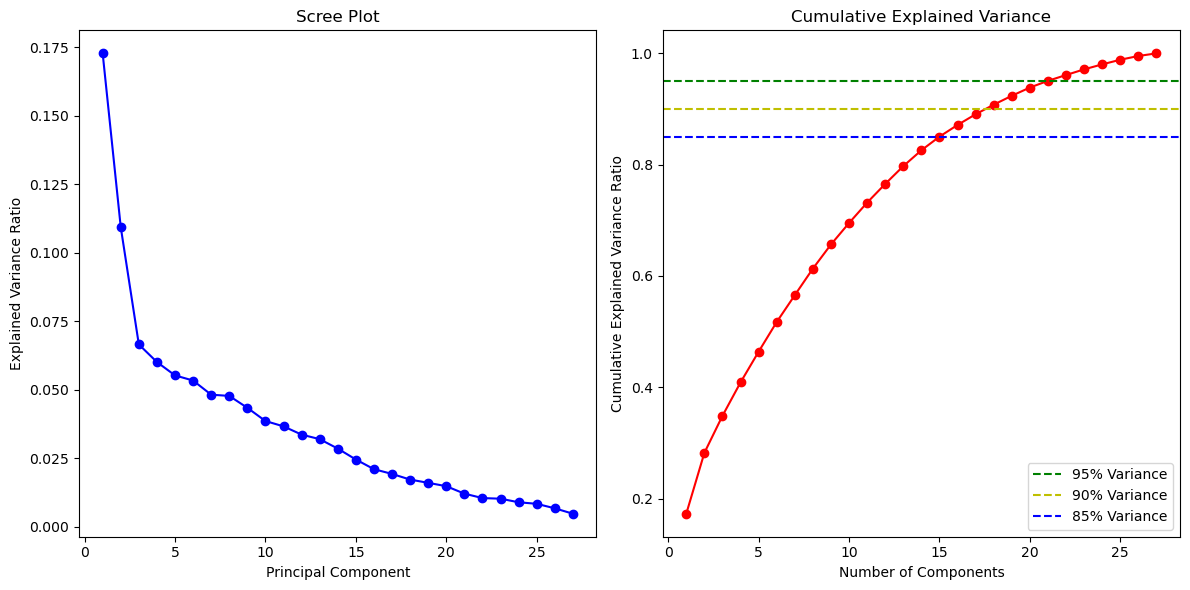

Number of components needed for 85.0% variance: 15
Number of components needed for 90.0% variance: 18
Number of components needed for 95.0% variance: 21

Top 5 components explained variance:
PC1: 0.1728
PC2: 0.1093
PC3: 0.0665
PC4: 0.0601
PC5: 0.0552


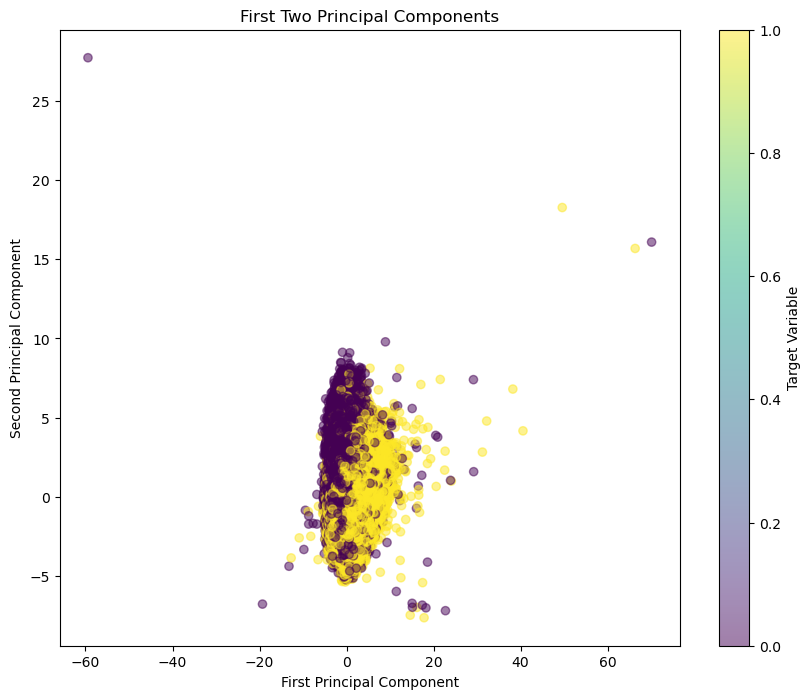


PCA transformation completed with 18 components
Transformed datasets saved successfully!


In [21]:
# Apply VIF-based feature selection
X_train_lr_vif = select_low_vif_features(X_train_lr)
# Make sure val/test have same columns
X_val_lr_vif = X_val_lr[X_train_lr_vif.columns]
X_test_lr_vif = X_test_lr[X_train_lr_vif.columns]

# Save VIF-selected datasets
import os
from pathlib import Path

# Create save directory if it doesn't exist
save_dir = Path('../data/processed/vif_selected')
save_dir.mkdir(parents=True, exist_ok=True)

# Save training set
X_train_lr_vif.to_csv(save_dir / 'X_train_lr_vif.csv', index=False)
y_train.to_csv(save_dir / 'y_train_lr_vif.csv', index=False)

# Save validation set
X_val_lr_vif.to_csv(save_dir / 'X_val_lr_vif.csv', index=False)
y_val.to_csv(save_dir / 'y_val_lr_vif.csv', index=False)

# Save test set
X_test_lr_vif.to_csv(save_dir / 'X_test_lr_vif.csv', index=False)
y_test.to_csv(save_dir / 'y_test_lr_vif.csv', index=False)

print("All VIF-selected datasets have been saved successfully!")
print(f"Files are saved in: {save_dir.absolute()}")

## PCA Analysis and Visualization
# Import necessary libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lr_vif)
X_val_scaled = scaler.transform(X_val_lr_vif)
X_test_scaled = scaler.transform(X_test_lr_vif)

# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Create visualization
plt.figure(figsize=(12, 6))

# Plot 1: Scree plot (individual explained variance)
plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

# Plot 2: Cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), 
         cumulative_variance_ratio, 'ro-')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Variance')
plt.axhline(y=0.90, color='y', linestyle='--', label='90% Variance')
plt.axhline(y=0.85, color='b', linestyle='--', label='85% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.legend()

plt.tight_layout()
plt.show()

# Print the number of components needed for different variance thresholds
variance_thresholds = [0.85, 0.90, 0.95]
for threshold in variance_thresholds:
    n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
    print(f"Number of components needed for {threshold*100}% variance: {n_components}")

# Print top 5 components' explained variance
print("\nTop 5 components explained variance:")
for i, var in enumerate(pca.explained_variance_ratio_[:5]):
    print(f"PC{i+1}: {var:.4f}")

# Visualize first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.values.ravel(), 
           cmap='viridis', alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('First Two Principal Components')
plt.colorbar(label='Target Variable')
plt.show()

# Save PCA transformed data
n_components = np.argmax(cumulative_variance_ratio >= 0.90) + 1  # Using 90% variance threshold
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Save PCA transformed datasets
pca_dir = Path("../data/processed/pca_transformed")
pca_dir.mkdir(parents=True, exist_ok=True)

# Save training set
pd.DataFrame(X_train_pca).to_csv(pca_dir / "X_train_pca.csv", index=False)
y_train.to_csv(pca_dir / "y_train_pca.csv", index=False)

# Save validation set
pd.DataFrame(X_val_pca).to_csv(pca_dir / "X_val_pca.csv", index=False)
y_val.to_csv(pca_dir / "y_val_pca.csv", index=False)

# Save test set
pd.DataFrame(X_test_pca).to_csv(pca_dir / "X_test_pca.csv", index=False)
y_test.to_csv(pca_dir / "y_test_pca.csv", index=False)

print(f"\nPCA transformation completed with {n_components} components")
print("Transformed datasets saved successfully!")

In [22]:
# Print the number of features in each dataset
print("Number of features in VIF-selected datasets:")
print(f"Training set: {X_train_lr_vif.shape[1]} features")
print(f"Validation set: {X_val_lr_vif.shape[1]} features")
print(f"Test set: {X_test_lr_vif.shape[1]} features")

# Print the feature names
print("\nSelected features:")
print(X_train_lr_vif.columns.tolist())

Number of features in VIF-selected datasets:
Training set: 27 features
Validation set: 27 features
Test set: 27 features

Selected features:
['age', 'height', 'waistline', 'sight_left', 'sight_right', 'hear_left', 'hear_right', 'DBP', 'BLDS', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'SMK_stat_type_cd', 'BMI', 'pulse_pressure', 'AST_ALT_ratio', 'risk_bp', 'risk_tg', 'risk_chole', 'risk_glu', 'sex_Male_True']


c:\Users\ola\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ola\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ola\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ola\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ola\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(execu

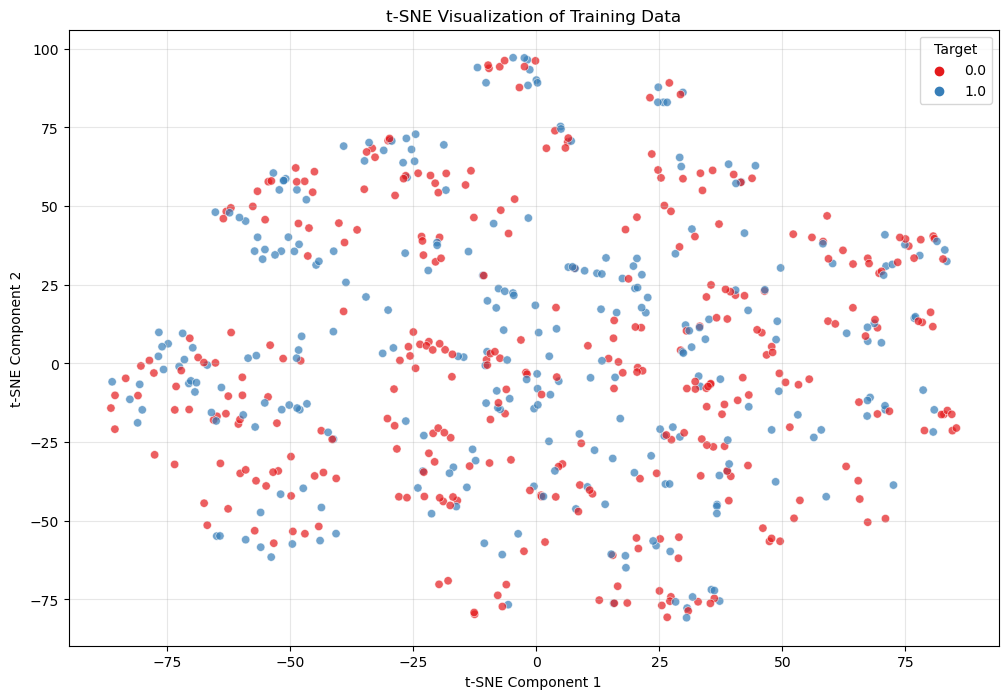

t-SNE results saved to ..\data\processed\X_train_tsne_sample.csv


In [23]:
## 10. Dimensionality Reduction with t-SNE
import sys
from pathlib import Path
import importlib

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Import and reload preprocessing module
import scripts.preprocessing
importlib.reload(scripts.preprocessing)

# Import t-SNE functions
from scripts.preprocessing import apply_tsne, plot_tsne, save_tsne_results

# Apply t-SNE to training data
X_tsne, tsne_df = apply_tsne(
    X=X_train_lr,  # Standardized training features
    y=y_train,         # Training labels
    sample_size=20000,  # Number of samples for t-SNE
    perplexity=30,     # Default perplexity value
    n_iter=1000        # Number of iterations
)

# Visualize t-SNE results
plot_tsne(
    tsne_df,
    title='t-SNE Visualization of Training Data',
    figsize=(12, 8)
)

# Save t-SNE results
save_tsne_results(
    tsne_df,
    output_path=OUTPUT_DIR / 'X_train_tsne_sample.csv'
)